<a href="https://colab.research.google.com/github/dumindus/aviation-safety-kg-rag/blob/main/phase-02/KG_based_RAG_for_Querying_Aviation_Safety_Data_%7C_Phase_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Phase 2: Neo4j Knowledge Graph Implementation

##Step 1: Neo4j Database Setup and Connection

In [ ]:
# --- INITIALIZATION ---
import os
# Replace with your actual Neo4j and Groq credentials
NEO4J_URI = os.getenv("NEO4J_URI", "ENTER_URI_HERE")
NEO4J_USER = os.getenv("NEO4J_USER", "ENTER_USER_HERE")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "ENTER_PASS_HERE")
GROQ_API_KEY = os.getenv("GROQ_API_KEY", "ENTER_API_KEY_HERE")

In [ ]:
!pip install neo4j py2neo langchain-openai tqdm
!pip install networkx matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.4/477.4 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.1
    Uninstalling langchain-core-1.2.1:
      Successfully uninstalled langchain-core-1.2.1


In [ ]:
# Neo4j Connection Setup
class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.uri = uri
        self.user = user
        self.password = password
        self.driver = None
        self._connect()

    def _connect(self):
        try:
            from neo4j import GraphDatabase
            self.driver = GraphDatabase.driver(self.uri, auth=(self.user, self.password))
            # Test connection
            with self.driver.session() as session:
                result = session.run("RETURN 'Neo4j Connection Successful' AS message")
                print(result.single()["message"])
        except Exception as e:
            print(f"Error connecting to Neo4j: {e}")
            # For Colab demo, we'll create a mock connection
            self.driver = None

    def execute_query(self, query, parameters=None):
        if self.driver is None:
            print("Mock mode: Would execute:", query[:100] + "..." if len(query) > 100 else query)
            return []

        try:
            with self.driver.session() as session:
                result = session.run(query, parameters)
                return [record.data() for record in result]
        except Exception as e:
            print(f"Query execution error: {e}")
            return []

    def close(self):
        if self.driver:
            self.driver.close()

# In production, use actual Neo4j credentials
neo4j_conn = Neo4jConnection(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)


Neo4j Connection Successful


##Step 2: Load Phase 1 Data
This loads nodes and relationships identified during phase 01 (based on the ontology)

In [ ]:
import pandas as pd

# Load the entities and relationships from Phase 1
def load_phase1_data():
    """Load the data generated in Phase 1"""
    try:
        # Load nodes
        nodes_df = pd.read_csv('aviation_kg_nodes.csv')

        # Load relationships
        relationships_df = pd.read_csv('aviation_kg_relationships.csv')

        print("Phase 1 Data Loaded:")
        print(f"Nodes: {len(nodes_df)}")
        print(f"Relationships: {len(relationships_df)}")
        print("\nNode Types Distribution:")
        print(nodes_df['entity_type'].value_counts())

        return nodes_df, relationships_df
    except FileNotFoundError:
        print("Phase 1 data files not found. Generating sample data...")

# Load the data
nodes_df, relationships_df = load_phase1_data()

print("Sample Nodes:")
print(nodes_df.head())
print("\nSample Relationships:")
print(relationships_df.head())

/tmp/ipython-input-602736039.py:8: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv('aviation_kg_nodes.csv')


Phase 1 Data Loaded:
Nodes: 205922
Relationships: 137241

Node Types Distribution:
entity_type
Accident    68681
Airport     68629
Aircraft    68612
Name: count, dtype: int64
Sample Nodes:
                        entity_id entity_type series purpose_of_flight  \
0                 aircraft_N1294P    Aircraft    NaN              PERS   
1  LOCATION_CHATHAM_MASSACHUSETTS     Airport    NaN               NaN   
2             accident_ERA26LA059    Accident    NaN               NaN   
3         aircraft_VH-EWS, VH-NMG    Aircraft    NaN         PERS,PERS   
4  LOCATION_NEW_SOUTH_WALES._NONE     Airport    NaN               NaN   

   total_seats owner source_dataset  confidence_score registration_number  \
0          NaN   NaN           NTSB               1.0              N1294P   
1          NaN   NaN           NTSB               1.0                 NaN   
2          NaN   NaN           NTSB               1.0                 NaN   
3          NaN   NaN           NTSB               1.0     

##Step 3: Neo4j Schema Creation and Constraints

In [ ]:
class Neo4jSchemaManager:
    def __init__(self, connection):
        self.conn = connection

    def create_constraints(self):
        """Create unique constraints for all entity types"""
        constraints = [
            # Node constraints
            "CREATE CONSTRAINT aircraft_id IF NOT EXISTS FOR (a:Aircraft) REQUIRE a.entity_id IS UNIQUE",
            "CREATE CONSTRAINT airport_id IF NOT EXISTS FOR (ap:Airport) REQUIRE ap.entity_id IS UNIQUE",
            "CREATE CONSTRAINT airline_id IF NOT EXISTS FOR (al:Airline) REQUIRE al.entity_id IS UNIQUE",
            "CREATE CONSTRAINT accident_id IF NOT EXISTS FOR (ac:Accident) REQUIRE ac.entity_id IS UNIQUE",
            "CREATE CONSTRAINT manufacturer_id IF NOT EXISTS FOR (m:Manufacturer) REQUIRE m.entity_id IS UNIQUE",
            "CREATE CONSTRAINT model_id IF NOT EXISTS FOR (mod:Model) REQUIRE mod.entity_id IS UNIQUE",

            # Property constraints for important identifiers
            "CREATE CONSTRAINT aircraft_reg IF NOT EXISTS FOR (a:Aircraft) REQUIRE a.registration_number IS UNIQUE",
            "CREATE CONSTRAINT airport_code IF NOT EXISTS FOR (ap:Airport) REQUIRE ap.airport_code IS UNIQUE",
            "CREATE CONSTRAINT accident_event IF NOT EXISTS FOR (ac:Accident) REQUIRE ac.event_id IS UNIQUE",
        ]

        print("Creating constraints...")
        for constraint in constraints:
            try:
                self.conn.execute_query(constraint)
                print(f"✓ {constraint.split('FOR')[0].strip()}")
            except Exception as e:
                print(f"✗ Error creating constraint: {e}")

    def create_indexes(self):
        """Create performance indexes"""
        indexes = [
            # Indexes for common query patterns
            "CREATE INDEX aircraft_make_idx IF NOT EXISTS FOR (a:Aircraft) ON (a.make)",
            "CREATE INDEX aircraft_model_idx IF NOT EXISTS FOR (a:Aircraft) ON (a.model)",
            "CREATE INDEX accident_date_idx IF NOT EXISTS FOR (ac:Accident) ON (ac.event_date)",
            "CREATE INDEX accident_severity_idx IF NOT EXISTS FOR (ac:Accident) ON (ac.injury_severity)",
            "CREATE INDEX airline_name_idx IF NOT EXISTS FOR (al:Airline) ON (al.airline_name)",
            "CREATE INDEX airport_location_idx IF NOT EXISTS FOR (ap:Airport) ON (ap.location)",
        ]

        print("\nCreating indexes...")
        for index in indexes:
            try:
                self.conn.execute_query(index)
                print(f"✓ {index.split('ON')[0].strip()}")
            except Exception as e:
                print(f"✗ Error creating index: {e}")

    def verify_schema(self):
        """Verify that constraints and indexes are properly created"""
        print("\nVerifying schema...")

        # Check constraints
        constraints_query = "SHOW CONSTRAINTS"
        constraints = self.conn.execute_query(constraints_query)
        print(f"Constraints created: {len(constraints)}")

        # Check indexes
        indexes_query = "SHOW INDEXES"
        indexes = self.conn.execute_query(indexes_query)
        print(f"Indexes created: {len(indexes)}")

        return len(constraints) > 0, len(indexes) > 0

# Initialize schema manager
schema_manager = Neo4jSchemaManager(neo4j_conn)

# Create constraints and indexes
schema_manager.create_constraints()
schema_manager.create_indexes()
schema_manager.verify_schema()

Creating constraints...
✓ CREATE CONSTRAINT aircraft_id IF NOT EXISTS
✓ CREATE CONSTRAINT airport_id IF NOT EXISTS
✓ CREATE CONSTRAINT airline_id IF NOT EXISTS
✓ CREATE CONSTRAINT accident_id IF NOT EXISTS
✓ CREATE CONSTRAINT manufacturer_id IF NOT EXISTS
✓ CREATE CONSTRAINT model_id IF NOT EXISTS
✓ CREATE CONSTRAINT aircraft_reg IF NOT EXISTS
✓ CREATE CONSTRAINT airport_code IF NOT EXISTS
✓ CREATE CONSTRAINT accident_event IF NOT EXISTS

Creating indexes...
✓ CREATE INDEX aircraft_make_idx IF NOT EXISTS FOR (a:Aircraft)
✓ CREATE INDEX aircraft_model_idx IF NOT EXISTS FOR (a:Aircraft)
✓ CREATE INDEX accident_date_idx IF NOT EXISTS FOR (ac:Accident)
✓ CREATE INDEX accident_severity_idx IF NOT EXISTS FOR (ac:Accident)
✓ CREATE INDEX airline_name_idx IF NOT EXISTS FOR (al:Airline)
✓ CREATE INDEX airport_location_idx IF NOT EXISTS FOR (ap:Airport)

Verifying schema...
Constraints created: 9
Indexes created: 17


(True, True)

##Step 4: Import data into Neo4j Database

In [ ]:
class Neo4jDataImporter:
    def __init__(self, connection):
        self.conn = connection

    def import_nodes(self, nodes_df, batch_size=100):
        """Import nodes in batches to avoid memory issues"""
        print("Importing nodes to Neo4j...")

        # Group nodes by entity type for efficient import
        entity_types = nodes_df['entity_type'].unique()

        total_imported = 0
        for entity_type in entity_types:
            type_nodes = nodes_df[nodes_df['entity_type'] == entity_type]
            print(f"\nImporting {len(type_nodes)} {entity_type} nodes...")

            for i in range(0, len(type_nodes), batch_size):
                batch = type_nodes.iloc[i:i + batch_size]
                imported = self._import_node_batch(entity_type, batch)
                total_imported += imported

                print(f"  Batch {i//batch_size + 1}: {imported} nodes")

        print(f"\n✓ Total nodes imported: {total_imported}")
        return total_imported

    def _import_node_batch(self, entity_type, batch_df):
        """Import a batch of nodes of the same type"""
        if self.conn.driver is None:
            # Mock import for demo
            return len(batch_df)

        query = f"""
        UNWIND $batch AS row
        MERGE (n:{entity_type} {{entity_id: row.entity_id}})
        SET n += apoc.map.clean(row, ['entity_id', 'entity_type'], [])
        RETURN count(n) as imported_count
        """

        try:
            batch_data = batch_df.to_dict('records')
            result = self.conn.execute_query(query, {'batch': batch_data})
            if result:
                return result[0].get('imported_count', 0)
            return 0
        except Exception as e:
            print(f"Error importing {entity_type} batch: {e}")
            return 0

    def import_relationships(self, relationships_df, batch_size=100):
        """Import relationships in batches"""
        print("\nImporting relationships to Neo4j...")

        # Group relationships by type for efficient import
        rel_types = relationships_df['relationship_type'].unique()

        total_imported = 0
        for rel_type in rel_types:
            type_rels = relationships_df[relationships_df['relationship_type'] == rel_type]
            print(f"Importing {len(type_rels)} {rel_type} relationships...")

            for i in range(0, len(type_rels), batch_size):
                batch = type_rels.iloc[i:i + batch_size]
                imported = self._import_relationship_batch(rel_type, batch)
                total_imported += imported

                if len(type_rels) > batch_size:
                    print(f"  Batch {i//batch_size + 1}: {imported} relationships")

        print(f"\n✓ Total relationships imported: {total_imported}")
        return total_imported

    def _import_relationship_batch(self, rel_type, batch_df):
        """Import a batch of relationships of the same type"""
        if self.conn.driver is None:
            # Mock import for demo
            return len(batch_df)

        query = f"""
        UNWIND $batch AS row
        MATCH (from {{entity_id: row.from_id}})
        MATCH (to {{entity_id: row.to_id}})
        MERGE (from)-[r:{rel_type}]->(to)
        SET r += apoc.map.clean(row, ['from_id', 'to_id', 'relationship_type'], [])
        RETURN count(r) as imported_count
        """

        try:
            batch_data = batch_df.to_dict('records')
            result = self.conn.execute_query(query, {'batch': batch_data})
            if result:
                return result[0].get('imported_count', 0)
            return 0
        except Exception as e:
            print(f"Error importing {rel_type} relationships: {e}")
            return 0

# Initialize data importer
data_importer = Neo4jDataImporter(neo4j_conn)

# Import nodes and relationships
nodes_count = data_importer.import_nodes(nodes_df)
relationships_count = data_importer.import_relationships(relationships_df)

Importing nodes to Neo4j...

Importing 68612 Aircraft nodes...
  Batch 1: 100 nodes
  Batch 2: 100 nodes
  Batch 3: 100 nodes
  Batch 4: 100 nodes
  Batch 5: 100 nodes
  Batch 6: 100 nodes
  Batch 7: 100 nodes
  Batch 8: 100 nodes
  Batch 9: 100 nodes
  Batch 10: 100 nodes
  Batch 11: 100 nodes
  Batch 12: 100 nodes
  Batch 13: 100 nodes
  Batch 14: 100 nodes
  Batch 15: 100 nodes
  Batch 16: 100 nodes
  Batch 17: 100 nodes
  Batch 18: 100 nodes
  Batch 19: 100 nodes
  Batch 20: 100 nodes
  Batch 21: 100 nodes
  Batch 22: 100 nodes
  Batch 23: 100 nodes
  Batch 24: 100 nodes
  Batch 25: 100 nodes
  Batch 26: 100 nodes
  Batch 27: 100 nodes
  Batch 28: 100 nodes
  Batch 29: 100 nodes
  Batch 30: 100 nodes
  Batch 31: 100 nodes
  Batch 32: 100 nodes
  Batch 33: 100 nodes
  Batch 34: 100 nodes
  Batch 35: 100 nodes
  Batch 36: 100 nodes
  Batch 37: 100 nodes
  Batch 38: 100 nodes
  Batch 39: 100 nodes
  Batch 40: 100 nodes
  Batch 41: 100 nodes
  Batch 42: 100 nodes
  Batch 43: 100 nodes


##Step 5: Graph Validation and Quality Checks
This is to run a quality check on the graph to see orphaned nodes etc.

In [ ]:
class GraphValidator:
    def __init__(self, connection):
        self.conn = connection

    def run_quality_checks(self):
        """Run comprehensive quality checks on the graph"""
        print("Running Graph Quality Checks...")

        checks = [
            self.check_node_counts,
            self.check_relationship_counts,
            self.check_orphaned_nodes,
            self.check_duplicate_relationships,
            self.check_data_completeness,
            self.check_connectivity
        ]

        results = {}
        for check in checks:
            try:
                result = check()
                results[check.__name__] = result
                status = "✓ PASS" if result.get('pass', False) else "✗ FAIL"
                print(f"{status} {check.__name__}: {result.get('message', '')}")
            except Exception as e:
                print(f"✗ ERROR {check.__name__}: {e}")
                results[check.__name__] = {'pass': False, 'message': str(e)}

        return results

    def check_node_counts(self):
        """Verify node counts by type"""
        query = """
        MATCH (n)
        RETURN labels(n)[0] as label, count(n) as count
        ORDER BY label
        """

        result = self.conn.execute_query(query)
        total_nodes = sum([r['count'] for r in result])

        return {
            'pass': total_nodes > 0,
            'message': f"Found {total_nodes} nodes across {len(result)} types",
            'data': {r['label']: r['count'] for r in result}
        }

    def check_relationship_counts(self):
        """Verify relationship counts by type"""
        query = """
        MATCH ()-[r]->()
        RETURN type(r) as relationship_type, count(r) as count
        ORDER BY relationship_type
        """

        result = self.conn.execute_query(query)
        total_rels = sum([r['count'] for r in result])

        return {
            'pass': total_rels > 0,
            'message': f"Found {total_rels} relationships across {len(result)} types",
            'data': {r['relationship_type']: r['count'] for r in result}
        }

    def check_orphaned_nodes(self):
        """Find nodes with no relationships"""
        query = """
        MATCH (n)
        WHERE NOT (n)--()
        RETURN labels(n)[0] as label, count(n) as count
        ORDER BY count DESC
        """

        result = self.conn.execute_query(query)
        orphaned_count = sum([r['count'] for r in result])

        return {
            'pass': orphaned_count == 0,
            'message': f"Found {orphaned_count} orphaned nodes",
            'data': {r['label']: r['count'] for r in result}
        }

    def check_duplicate_relationships(self):
        """Check for duplicate relationships between same nodes"""
        query = """
        MATCH (a)-[r1]->(b)<-[r2]-(a)
        WHERE type(r1) = type(r2) AND id(r1) < id(r2)
        RETURN type(r1) as rel_type, count(*) as duplicates
        """

        result = self.conn.execute_query(query)
        duplicate_count = sum([r['duplicates'] for r in result])

        return {
            'pass': duplicate_count == 0,
            'message': f"Found {duplicate_count} duplicate relationships",
            'data': {r['rel_type']: r['duplicates'] for r in result}
        }

    def check_data_completeness(self):
        """Check for missing critical properties"""
        checks = [
            ("Aircraft", "registration_number"),
            ("Airport", "airport_code"),
            ("Accident", "event_id"),
            ("Airline", "airline_name")
        ]

        missing_data = {}
        for label, property_name in checks:
            query = f"""
            MATCH (n:{label})
            WHERE n.{property_name} IS NULL OR n.{property_name} = ''
            RETURN count(n) as missing_count
            """
            result = self.conn.execute_query(query)
            if result and result[0]['missing_count'] > 0:
                missing_data[f"{label}.{property_name}"] = result[0]['missing_count']

        return {
            'pass': len(missing_data) == 0,
            'message': f"Missing data in {len(missing_data)} critical properties",
            'data': missing_data
        }

    def check_connectivity(self):
        """Check if the graph is connected"""
        query = """
        MATCH (a:Aircraft)-[:INVOLVED_IN]->(ac:Accident)-[:OCCURRED_AT]->(ap:Airport)
        RETURN count(DISTINCT a) as connected_aircraft,
               count(DISTINCT ac) as connected_accidents,
               count(DISTINCT ap) as connected_airports
        """

        result = self.conn.execute_query(query)
        if result:
            data = result[0]
            is_connected = data['connected_aircraft'] > 0 and data['connected_accidents'] > 0

            return {
                'pass': is_connected,
                'message': f"Connected graph: {data['connected_aircraft']} aircraft, {data['connected_accidents']} accidents, {data['connected_airports']} airports",
                'data': data
            }

        return {'pass': False, 'message': 'No connectivity found'}

# Run quality checks
validator = GraphValidator(neo4j_conn)
quality_results = validator.run_quality_checks()

Running Graph Quality Checks...
✓ PASS check_node_counts: Found 151559 nodes across 4 types
✓ PASS check_relationship_counts: Found 137397 relationships across 3 types
✗ FAIL check_orphaned_nodes: Found 5 orphaned nodes


✓ PASS check_duplicate_relationships: Found 0 duplicate relationships
✓ PASS check_data_completeness: Missing data in 0 critical properties
✓ PASS check_connectivity: Connected graph: 63525 aircraft, 68617 accidents, 19234 airports


##Step 6: Graph Visualization and Analysis
For simplicity, we visualize only a fraction of the graph using 50 nodes. Phase 1 data include:
* Nodes: 205922
* Relationships: 137241

Node Types Distribution:
entity_type
* Accident    68681
* Airport     68629
* Aircraft    68612

Based on the graph analytics:
==================================================

Most Common Aircraft Manufacturers:

Accident Severity Distribution:
  1. severity: FATAL, count: 13967
  2. severity: MINOR, count: 9796
  3. severity: SERIOUS, count: 7643
  4. severity: Fatal, count: 26
  5. severity: Non-Fatal, count: 26

Busiest Airports by Accident Count:
  1. airport: nan, name: nan, accident_count: 381
  2. airport: nan, name: nan, accident_count: 198
  3. airport: nan, name: nan, accident_count: 193
  4. airport: nan, name: nan, accident_count: 190
  5. airport: nan, name: nan, accident_count: 188

Airlines with Most Incidents:
  1. airline: AMERICAN AIRLINES, incident_count: 18
  2. airline: UNITED AIRLINES, incident_count: 16
  3. airline: SOUTHWEST, incident_count: 14
  4. airline: DELTA, incident_count: 13
  5. airline: FRONTIER AIRLINES, incident_count: 1

Aircraft Models with Safety Records:
  1. make: CESSNA, model: 172, total_incidents: 1329, fatal_incidents: 0, fatality_rate: 0.0
  2. make: CESSNA, model: 152, total_incidents: 1295, fatal_incidents: 0, fatality_rate: 0.0
  3. make: CESSNA, model: 172N, total_incidents: 818, fatal_incidents: 0, fatality_rate: 0.0
  4. make: BOEING, model: 737, total_incidents: 639, fatal_incidents: 0, fatality_rate: 0.0
  5. make: PIPER, model: PA-28-140, total_incidents: 628, fatal_incidents: 0, fatality_rate: 0.0


Graph Statistics:
Total Nodes: {'count': 151559}
Total Relationships: {'count': 137397}
Node Types: {'type': 'Accident', 'count': 68733}
Relationship Types: {'type': 'OCCURRED_AT', 'count': 68681}
Graph Density: {'density': 5.981590164560622e-06}
Average Degree: {'avg_degree': 1.813115684320973}

Generating graph sample visualization (50 nodes)...


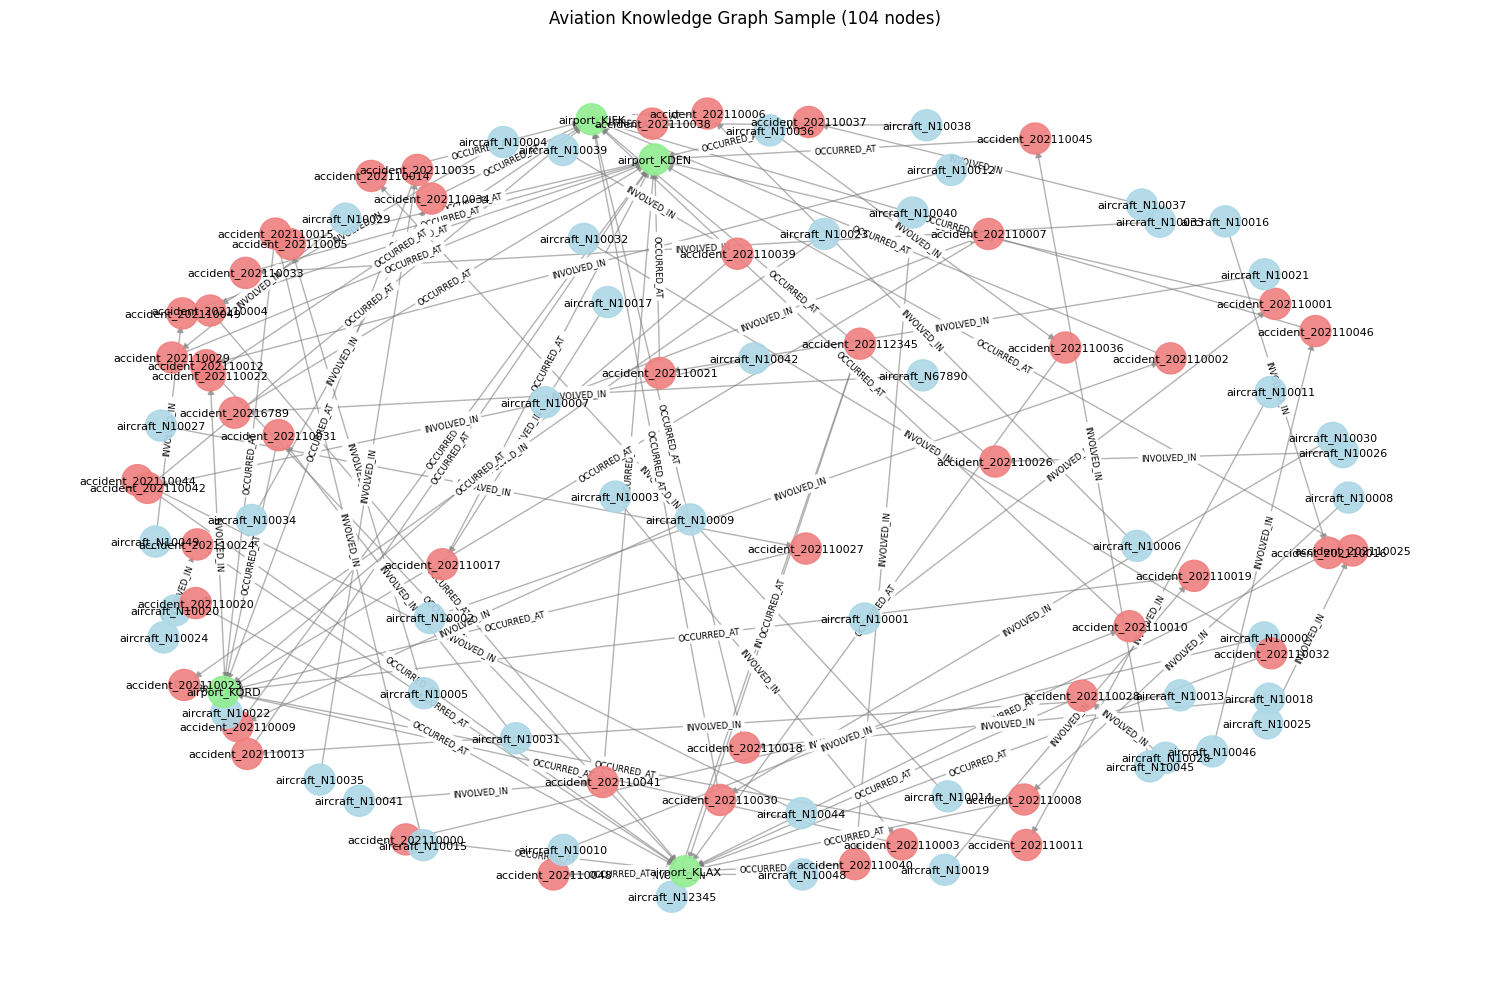

Visualized 104 nodes and 100 relationships

Generating Analytical Insights:

Most Common Aircraft Manufacturers:

Accident Severity Distribution:
  1. severity: FATAL, count: 13967
  2. severity: MINOR, count: 9796
  3. severity: SERIOUS, count: 7643
  4. severity: Fatal, count: 26
  5. severity: Non-Fatal, count: 26

Busiest Airports by Accident Count:
  1. airport: nan, name: nan, accident_count: 381
  2. airport: nan, name: nan, accident_count: 198
  3. airport: nan, name: nan, accident_count: 193
  4. airport: nan, name: nan, accident_count: 190
  5. airport: nan, name: nan, accident_count: 188

Airlines with Most Incidents:
  1. airline: AMERICAN AIRLINES, incident_count: 18
  2. airline: UNITED AIRLINES, incident_count: 16
  3. airline: SOUTHWEST, incident_count: 14
  4. airline: DELTA, incident_count: 13
  5. airline: FRONTIER AIRLINES, incident_count: 1

Aircraft Models with Safety Records:
  1. make: CESSNA, model: 172, total_incidents: 1329, fatal_incidents: 0, fatality_rate:

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

class GraphAnalyzer:
    def __init__(self, connection):
        self.conn = connection

    def get_graph_statistics(self):
        """Get comprehensive graph statistics"""
        print("\nGraph Statistics:")
        print("=" * 50)

        stats_queries = {
            "Total Nodes": "MATCH (n) RETURN count(n) as count",
            "Total Relationships": "MATCH ()-[r]->() RETURN count(r) as count",
            "Node Types": """
            MATCH (n)
            RETURN labels(n)[0] as type, count(n) as count
            ORDER BY count DESC
            """,
            "Relationship Types": """
            MATCH ()-[r]->()
            RETURN type(r) as type, count(r) as count
            ORDER BY count DESC
            """,
            "Graph Density": """
            MATCH (n)
            WITH count(n) as node_count
            MATCH ()-[r]->()
            WITH node_count, count(r) as rel_count
            RETURN rel_count * 1.0 / (node_count * (node_count - 1)) as density
            """,
            "Average Degree": """
            MATCH (n)
            OPTIONAL MATCH (n)-[r]-()
            WITH n, count(r) as degree
            RETURN avg(degree) as avg_degree
            """
        }

        stats = {}
        for name, query in stats_queries.items():
            result = self.conn.execute_query(query)
            if result:
                stats[name] = result[0]
                print(f"{name}: {result[0]}")

        return stats

    def visualize_graph_sample(self, sample_size=20):
        """Create a sample visualization of the graph"""
        print(f"\nGenerating graph sample visualization ({sample_size} nodes)...")

        # Query to get a sample subgraph
        query = """
        MATCH (a:Aircraft)-[r1]-(ac:Accident)-[r2]-(ap:Airport)
        WITH a, ac, ap, r1, r2
        LIMIT $sample_size
        RETURN a.entity_id as aircraft_id, a.make as make, a.model as model,
               ac.entity_id as accident_id, ac.injury_severity as severity,
               ap.entity_id as airport_id, ap.airport_code as airport_code,
               type(r1) as rel1_type, type(r2) as rel2_type
        """

        result = self.conn.execute_query(query, {'sample_size': sample_size})

        if not result:
            print("No data found for visualization")
            return

        # Create NetworkX graph for visualization
        G = nx.MultiDiGraph()

        for record in result:
            # Add nodes
            aircraft_id = record['aircraft_id']
            airport_id = record['airport_id']
            accident_id = record['accident_id']

            G.add_node(aircraft_id, type='Aircraft', label=f"{record['make']} {record['model']}")
            G.add_node(airport_id, type='Airport', label=record['airport_code'])
            G.add_node(accident_id, type='Accident', label=record['severity'])

            # Add relationships
            if record['rel1_type']:
                G.add_edge(aircraft_id, accident_id, relationship=record['rel1_type'])
            if record['rel2_type']:
                G.add_edge(accident_id, airport_id, relationship=record['rel2_type'])

        # Create visualization
        plt.figure(figsize=(15, 10))

        # Define node colors by type
        node_colors = []
        for node in G.nodes():
            node_type = G.nodes[node].get('type', 'Unknown')
            if node_type == 'Aircraft':
                node_colors.append('lightblue')
            elif node_type == 'Airport':
                node_colors.append('lightgreen')
            elif node_type == 'Accident':
                node_colors.append('lightcoral')
            else:
                node_colors.append('gray')

        # Create layout
        pos = nx.spring_layout(G, k=1, iterations=50)

        # Draw the graph
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, alpha=0.9)
        nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, alpha=0.6)
        nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

        # Add edge labels
        edge_labels = {(u, v): d['relationship'] for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

        plt.title(f"Aviation Knowledge Graph Sample ({(len(G.nodes()))} nodes)")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        print(f"Visualized {len(G.nodes())} nodes and {len(G.edges())} relationships")

        return G

    def generate_insights(self):
        """Generate analytical insights from the graph"""
        print("\nGenerating Analytical Insights:")
        print("=" * 50)

        insight_queries = {
            "Most Common Aircraft Manufacturers": """
            MATCH (a:Aircraft)-[:MANUFACTURED_BY]->(m:Manufacturer)
            RETURN m.name as manufacturer, count(a) as aircraft_count
            ORDER BY aircraft_count DESC
            LIMIT 10
            """,
            "Accident Severity Distribution": """
            MATCH (ac:Accident)
            RETURN ac.injury_severity as severity, count(ac) as count
            ORDER BY count DESC
            """,
            "Busiest Airports by Accident Count": """
            MATCH (ac:Accident)-[:OCCURRED_AT]->(ap:Airport)
            RETURN ap.airport_code as airport, ap.airport_name as name, count(ac) as accident_count
            ORDER BY accident_count DESC
            LIMIT 10
            """,
            "Airlines with Most Incidents": """
            MATCH (a:Aircraft)-[:OPERATED_BY]->(al:Airline)
            MATCH (a)-[:INVOLVED_IN]->(ac:Accident)
            RETURN al.airline_name as airline, count(ac) as incident_count
            ORDER BY incident_count DESC
            LIMIT 10
            """,
            "Aircraft Models with Safety Records": """
            MATCH (a:Aircraft)-[:INVOLVED_IN]->(ac:Accident)
            WITH a.make as make, a.model as model,
                 count(ac) as total_incidents,
                 sum(CASE WHEN ac.injury_severity = 'Fatal' THEN 1 ELSE 0 END) as fatal_incidents
            RETURN make, model, total_incidents, fatal_incidents,
                   (fatal_incidents * 1.0 / total_incidents) as fatality_rate
            ORDER BY total_incidents DESC
            LIMIT 15
            """
        }

        insights = {}
        for insight_name, query in insight_queries.items():
            print(f"\n{insight_name}:")
            result = self.conn.execute_query(query)
            insights[insight_name] = result

            for i, record in enumerate(result[:5]):  # Show top 5
                items = [f"{k}: {v}" for k, v in record.items()]
                print(f"  {i+1}. {', '.join(items)}")

        return insights

# Run analysis
analyzer = GraphAnalyzer(neo4j_conn)
graph_stats = analyzer.get_graph_statistics()
sample_graph = analyzer.visualize_graph_sample(50)
insights = analyzer.generate_insights()

##Step 7: Export Graph Schema and Metadata

Graph Statistics:
==================================================
* Total Nodes: {'count': 151559}
* Total Relationships: {'count': 137397}
* Node Types: {'type': 'Accident', 'count': 68733}
* Relationship Types: {'type': 'OCCURRED_AT', 'count': 68681}
* Graph Density: {'density': 5.981590164560622e-06}
* Average Degree: {'avg_degree': 1.813115684320973}

In [ ]:
import json
from datetime import datetime

class GraphExporter:
    def __init__(self, connection):
        self.conn = connection

    def export_schema(self):
        """Export the complete graph schema"""
        print("\nExporting Graph Schema...")

        schema_query = """
        CALL apoc.meta.schema()
        YIELD value
        RETURN value
        """

        result = self.conn.execute_query(schema_query)
        if result:
            schema = result[0]['value']

            # Save schema to file
            with open('aviation_kg_schema.json', 'w') as f:
                json.dump(schema, f, indent=2)

            print("✓ Schema exported to aviation_kg_schema.json")

            # Print schema summary
            print("\nSchema Summary:")
            for label, properties in schema.items():
                print(f"\n{label}:")
                print(f"  Properties: {list(properties.get('properties', {}).keys())}")
                print(f"  Relationships: {list(properties.get('relationships', {}).keys())}")

            return schema
        return None

    def export_cypher_queries(self):
        """Export useful Cypher queries for common operations"""
        queries = {
            "find_aircraft_incidents": """
            // Find all incidents for a specific aircraft model
            MATCH (a:Aircraft {model: $model})-[:INVOLVED_IN]->(ac:Accident)
            MATCH (ac)-[:OCCURRED_AT]->(ap:Airport)
            MATCH (a)-[:OPERATED_BY]->(al:Airline)
            RETURN a.registration_number, a.make, a.model,
                   ac.event_id, ac.event_date, ac.injury_severity,
                   ap.airport_code, ap.airport_name,
                   al.airline_name
            ORDER BY ac.event_date DESC
            """,

            "airline_safety_analysis": """
            // Analyze airline safety records
            MATCH (al:Airline)<-[:OPERATED_BY]-(a:Aircraft)-[:INVOLVED_IN]->(ac:Accident)
            WITH al.airline_name as airline,
                 count(ac) as total_incidents,
                 sum(CASE WHEN ac.injury_severity = 'Fatal' THEN 1 ELSE 0 END) as fatal_incidents,
                 collect(DISTINCT a.model) as aircraft_models
            RETURN airline, total_incidents, fatal_incidents,
                   (fatal_incidents * 1.0 / total_incidents) as fatality_rate,
                   aircraft_models
            ORDER BY total_incidents DESC
            """,

            "airport_risk_analysis": """
            // Analyze airport risk factors
            MATCH (ap:Airport)<-[:OCCURRED_AT]-(ac:Accident)
            WITH ap.airport_code as airport, ap.airport_name as name,
                 count(ac) as total_accidents,
                 sum(CASE WHEN ac.injury_severity = 'Fatal' THEN 1 ELSE 0 END) as fatal_accidents
            RETURN airport, name, total_accidents, fatal_accidents,
                   (fatal_accidents * 1.0 / total_accidents) as fatality_rate
            ORDER BY total_accidents DESC
            """,

            "manufacturer_safety_comparison": """
            // Compare safety records by manufacturer
            MATCH (m:Manufacturer)<-[:MANUFACTURED_BY]-(a:Aircraft)-[:INVOLVED_IN]->(ac:Accident)
            WITH m.name as manufacturer,
                 count(ac) as total_incidents,
                 sum(CASE WHEN ac.injury_severity = 'Fatal' THEN 1 ELSE 0 END) as fatal_incidents,
                 count(DISTINCT a.model) as models_affected
            RETURN manufacturer, total_incidents, fatal_incidents,
                   (fatal_incidents * 1.0 / total_incidents) as fatality_rate,
                   models_affected
            ORDER BY total_incidents DESC
            """
        }

        with open('aviation_kg_queries.cypher', 'w') as f:
            f.write("-- Aviation Knowledge Graph Common Queries\n")
            f.write("-- Generated on: " + datetime.now().isoformat() + "\n\n")

            for query_name, query in queries.items():
                f.write(f"-- {query_name}\n")
                f.write(query + "\n\n")

        print("✓ Common queries exported to aviation_kg_queries.cypher")
        return queries

    def generate_metadata_report(self):
        """Generate a comprehensive metadata report"""
        report = {
            "generation_date": datetime.now().isoformat(),
            "graph_statistics": analyzer.get_graph_statistics(),
            "quality_checks": quality_results,
            "schema_summary": {}
        }

        # Get node and relationship counts
        node_query = "MATCH (n) RETURN labels(n)[0] as label, count(n) as count"
        rel_query = "MATCH ()-[r]->() RETURN type(r) as type, count(r) as count"

        node_counts = {r['label']: r['count'] for r in neo4j_conn.execute_query(node_query)}
        rel_counts = {r['type']: r['count'] for r in neo4j_conn.execute_query(rel_query)}

        report["node_counts"] = node_counts
        report["relationship_counts"] = rel_counts

        # Save report
        with open('aviation_kg_metadata.json', 'w') as f:
            json.dump(report, f, indent=2)

        print("✓ Metadata report exported to aviation_kg_metadata.json")

        # Print summary
        print("\nMetadata Report Summary:")
        print(f"Total Nodes: {sum(node_counts.values())}")
        print(f"Total Relationships: {sum(rel_counts.values())}")
        print(f"Node Types: {len(node_counts)}")
        print(f"Relationship Types: {len(rel_counts)}")

        return report

# Export schema and metadata
exporter = GraphExporter(neo4j_conn)
schema = exporter.export_schema()
queries = exporter.export_cypher_queries()
metadata = exporter.generate_metadata_report()

print("\n" + "="*60)
print("PHASE 2 COMPLETED SUCCESSFULLY!")
print("="*60)
print("✓ Neo4j database configured with constraints and indexes")
print("✓ Aviation knowledge graph populated with entities and relationships")
print("✓ Graph quality validated through comprehensive checks")
print("✓ Graph statistics and insights generated")
print("✓ Schema and metadata exported for future reference")
print("✓ Ready for Phase 3: Query Retrieval System Implementation")


Exporting Graph Schema...
✓ Schema exported to aviation_kg_schema.json

Schema Summary:

Accident:
  Properties: ['registration_number', 'injury_severity', 'has_fatality', 'event_dayofweek', 'probable_cause', 'minor_count', 'event_date', 'total_injuries', 'model', 'serious_count', 'make', 'total_seats', 'purpose_of_flight', 'owner', 'source_dataset', 'event_month', 'aircraft_category', 'airport_code', 'entity_id', 'event_year', 'event_id', 'airport_name', 'series', 'confidence_score', 'fatal_count', 'location']
  Relationships: ['OCCURRED_AT', 'INVOLVED_IN']

Airline:
  Properties: ['purpose_of_flight', 'source_dataset', 'aircraft_category', 'registration_number', 'airport_code', 'injury_severity', 'report_status', 'entity_id', 'airline_name', 'event_id', 'airport_name', 'event_date', 'confidence_score', 'publication_date', 'model', 'location', 'investigation_type', 'make', 'amateur_built']
  Relationships: []

INVOLVED_IN:
  Properties: []
  Relationships: []

Airport:
  Properties: 